In [1]:
import numpy as np
import sympy as sp

%matplotlib nbagg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import pyJHTDB
from pyJHTDB import libJHTDB
from pyJHTDB.dbinfo import interpolation_code
from pyJHTDB.dbinfo import channel as info

import pickle
from __future__ import division
import time

In [2]:
nu = 5e-5
T  = 25.9935


kolmogorov_time = 1e-3
kolmogorov_length = 1

Lx = info['lx']
Ly = info['ly']
Lz = info['lz']

Top = Ly/2
Bottom = -Ly/2
eps = Ly/100

npoints = 2
nparticles = 10
database_dt = 0.0065
nsteps = int(T/database_dt) #info['time'].shape[0]


subdivisions = 2
t = np.linspace(T, info['time'][0], num = subdivisions*nsteps+1)
tau = t[0]-t
dt              = t[0] - t[1]
sqrtdt          = abs(dt)**.5

x0         = np.zeros(shape = (npoints, nparticles, 3), dtype = np.float32)
x0[..., 0] = Lx*np.random.random(size = (npoints,))[:, None]
x0[..., 1] = info['ynodes'][info['ynodes'].shape[0]//10]
x0[..., 2] = Lz*np.random.random(size = (npoints,))[:, None]

numcombs   = np.float(nparticles*(nparticles-1)/2)
trytimes = [1,3,10,30,100,300,1000] #waiting times in case database fails   

In [3]:
#pickle.dump(x0, open( "data_channel/x0.p", "wb" ) )
x0 = pickle.load( open( "data_channel/x0.p", "rb" ) )

PrandtlNumbers = np.array([1e1, 1e0, 1e-1])
for m in range(PrandtlNumbers.shape[0]):
    x = x0.copy() 
    LB         = np.zeros(shape = (npoints, nparticles, 3), dtype = np.float32)
    LT         = np.zeros(shape = (npoints, nparticles, 3), dtype = np.float32)
    HT         = (info['time'][-1]+1)**2*np.ones(shape = (npoints, nparticles, 1), dtype = np.float32)
    r          = np.zeros(shape = (npoints, nparticles,  nparticles), dtype = np.float32)
    disp       = np.zeros(shape = (subdivisions*nsteps + 1, npoints), dtype = np.float32)
    
    Prandtl = np.float(PrandtlNumbers[m])
    kappa = nu/Prandtl
    noiseamplitude  = (2*kappa)**.5
    
    lJHTDB = libJHTDB()
    lJHTDB.initialize()
    for tindex in range(subdivisions*nsteps):
        print('step {0} of {1} for Pr = {2}'.format(tindex,subdivisions*nsteps, Prandtl))
        
        for tryT in trytimes:  
            try:
                u = lJHTDB.getData(
                            t[tindex],
                            x,
                            sinterp = interpolation_code['M2Q8'],
                            tinterp = interpolation_code['NoTInt'],
                            data_set = info['name'],
                            getFunction = 'getVelocity')
                break
            except Exception as e:
                print e
                time.sleep(tryT)
                
        dW = np.random.randn(*x.shape)*sqrtdt
        dX = -u*dt + noiseamplitude*dW
        x += dX
        for k in range(npoints):
            for i in range(nparticles):
                for j in range(nparticles):
                    if i<j:
                        r[k,i,j] =  np.sum(np.square(x[k, i, :] - x[k, j, :]))           
        disp[tindex + 1] = np.sum(np.sum(r, axis=2),axis=1)/float(numcombs)

        cond1 = x[..., 1] < Bottom + eps
        cond2 = x[..., 1] > Top    - eps
        HT[np.logical_or(cond1, cond2)] = np.minimum(HT[np.logical_or(cond1, cond2)], tau[tindex])
        c1indices = np.where(cond1)   
        if c1indices[0].size > 0:
            V  =  -2*dt*np.log(np.random.random(x.shape))[c1indices]
            Y  = (-dX[c1indices] + np.sqrt(2*kappa*V + dX[c1indices]**2))/2.0
            dL =  Y - x[c1indices] + Bottom
            dL[np.where(dL < 0)] = 0
            x[c1indices]  += dL
            LB[c1indices] += dL/kappa
        c2indices = np.where(cond2) 
        if c2indices[0].size > 0:
            V  =  -2*dt*np.log(np.random.random(x.shape))[c2indices]
            Y  = (-dX[c2indices] + np.sqrt(2*kappa*V + dX[c2indices]**2))/2.0
            dL =  Y + x[c2indices] - Top
            dL[np.where(dL < 0)] = 0
            x[c2indices]  -= dL
            LT[c2indices] += dL/kappa
        x[..., 1] = np.clip(x[..., 1], Bottom, Top)
    lJHTDB.finalize() 
    
    ####### Dump Data #######
    suffix = 'Traj_{0}_Pr_{1}.p'.format(nparticles, Prandtl)
    pickle.dump(x, open( "data_channel/x"          + suffix, "wb" ) )
    pickle.dump(t, open( "data_channel/t"           + suffix, "wb" ) )
    pickle.dump(LT, open( "data_channel/LT"         + suffix, "wb" ) )
    pickle.dump(LB, open( "data_channel/LB"         + suffix, "wb" ) )
    pickle.dump(HT, open( "data_channel/HT"         + suffix, "wb" ) )
    pickle.dump(disp, open( "data_channel/disp"     + suffix, "wb" ) )

IOError: [Errno 2] No such file or directory: 'data_channel/x0.p'

In [4]:
####### Load Data #######
PrandtlNumbers = np.array([1e1, 1e0, 1e-1])
nparticles = 1000
Prandtl1 = PrandtlNumbers[0]
Prandtl2 = PrandtlNumbers[1]
#Prandtl3 = PrandtlNumbers[2]
suffix1  = 'middle_Traj_{0}_Pr_{1}.p'.format(nparticles, Prandtl1)
suffix2  = 'middle_Traj_{0}_Pr_{1}.p'.format(nparticles, Prandtl2)
#suffix3  = 'middle_Traj_{0}_Pr_{1}.p'.format(nparticles, Prandtl3)
t        = pickle.load( open( "data_channel/t"     + suffix1, "rb" ) )
LT1      = pickle.load( open( "data_channel/LT"    + suffix1, "rb" ) )
LB1      = pickle.load( open( "data_channel/LB"    + suffix1, "rb" ) )
HT1      = pickle.load( open( "data_channel/HT"    + suffix1, "rb" ) )
disp1    = pickle.load( open( "data_channel/disp"  + suffix1, "rb" ) )
LT2      = pickle.load( open( "data_channel/LT"    + suffix2, "rb" ) )
LB2      = pickle.load( open( "data_channel/LB"    + suffix2, "rb" ) )
HT2      = pickle.load( open( "data_channel/HT"    + suffix2, "rb" ) )
disp2    = pickle.load( open( "data_channel/disp"  + suffix2, "rb" ) )
#LT3      = pickle.load( open( "data_channel/LT"    + suffix3, "rb" ) )
#LB3      = pickle.load( open( "data_channel/LB"    + suffix3, "rb" ) )
#HT3      = pickle.load( open( "data_channel/HT"    + suffix3, "rb" ) )
#disp3    = pickle.load( open( "data_channel/disp"  + suffix3, "rb" ) )

<IPython.core.display.Javascript object>


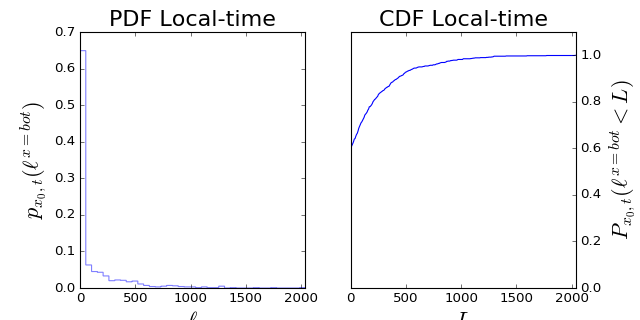

<IPython.core.display.Javascript object>


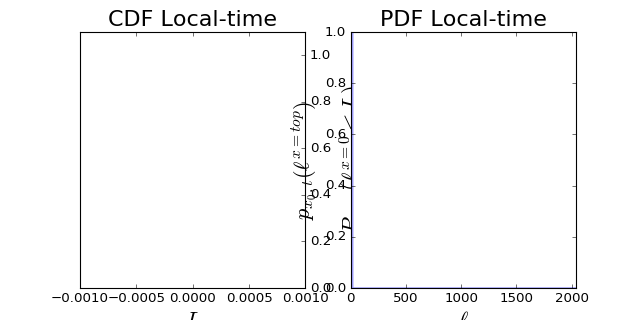

In [33]:
space_index   =  0
dataB         = LB2[space_index,:,1]
dataT         = LT2[space_index,:,1]
MB            = np.max(dataB)
MT            = np.max(dataT)

fig = plt.figure(figsize=(8,4))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
fig.subplots_adjust(hspace=.5)

####################################
######## BOTTOM LOCAL TIME #########
####################################

bins = np.linspace(0, MB, 40)
N = nparticles
weights = np.ones_like(dataB[:])/N
ax1.hist(dataB, weights = weights, bins = bins, alpha=0.5, histtype = 'step')
#ax1.hist(dataB, normed = 1, bins = bins, alpha=0.5, histtype = 'step')

ax1.set_title('PDF Local-time', fontsize=20)
ax1.set_xlim([0,MB])
ax1.set_xlabel('$\ell$', fontsize=20)
ax1.set_ylabel('$p_{x_0,t}(\\ell^{x=bot})$', fontsize=20)

values, base = np.histogram(dataB, bins = 300, normed = 0)
cumulative   = np.cumsum(values)/float(dataB.shape[0])
ax2.plot(base[:-1], cumulative, c='blue')

ax2.set_xlim([0,MB])
ax2.set_ylim([0,1.1])
ax2.set_title('CDF Local-time', fontsize=20)
ax2.set_xlabel('$L$', fontsize=20)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('$P_{x_0,t}(\\ell^{x=bot}<L)$', fontsize=20)


fig = plt.figure(figsize=(8,4))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
fig.subplots_adjust(hspace=.5)

####################################
########## TOP LOCAL TIME ##########
####################################

bins = np.linspace(0, MB, 100)
N = nparticles
weights = np.ones_like(dataT[:])/N
ax2.hist(dataT, weights = weights, bins = bins, alpha=0.5, histtype = 'step')

ax2.set_title('PDF Local-time', fontsize=20)
ax2.set_xlim([0,MB])
ax2.set_xlabel('$\ell$', fontsize=20)
ax2.set_ylabel('$p_{x_0,t}(\\ell^{x=top})$', fontsize=20)

values, base = np.histogram(dataT, bins = 300, normed = 0)
cumulative   = np.cumsum(values)/float(dataT.shape[0])
ax2.plot(base[:-1], cumulative, c='blue')

ax1.set_xlim([0,MT])
ax1.set_ylim([0,1.1])
ax1.set_title('CDF Local-time', fontsize=20)
ax1.set_xlabel('$L$', fontsize=20)
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")
ax1.set_ylabel('$P_{x_0,t}(\\ell^{x=0}<L)$', fontsize=20)

<IPython.core.display.Javascript object>


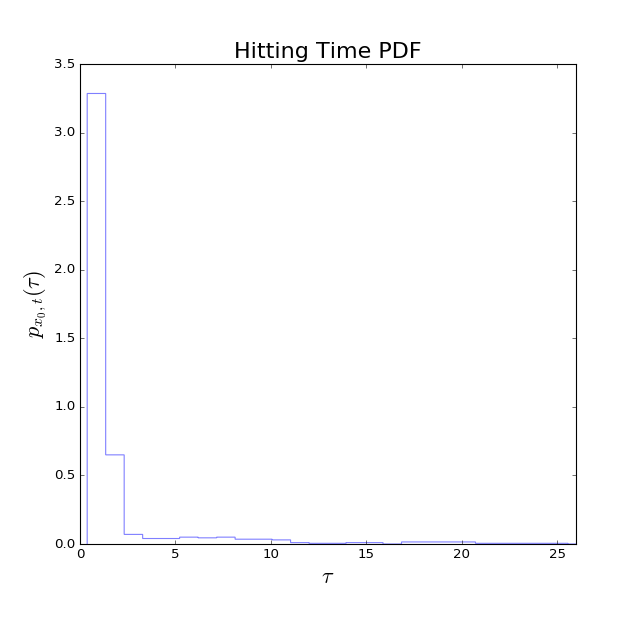

In [28]:
space_index1 = 0
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
fig.subplots_adjust(hspace=.5)

plt.gcf().subplots_adjust(bottom=0.15)

data1 = HT2[space_index1, :, np.newaxis]
data1 = data1[data1 < (T+1)**2]
MD1 = np.max(data1)

N = nparticles/5.
weights1 = np.ones_like(data1[:])/N

ax1.hist(data1, weights = weights1, bins = 60, alpha=0.5,  histtype = 'step')
taus = np.linspace(0.001, T, 350)
ax1.set_title('Hitting Time PDF', fontsize=20)
ax1.set_xlim([0,T])
ax1.set_xlabel('$\\tau$', fontsize=20)
ax1.set_ylabel('$p_{x_0,t}(\\tau)$', fontsize=20)

<IPython.core.display.Javascript object>


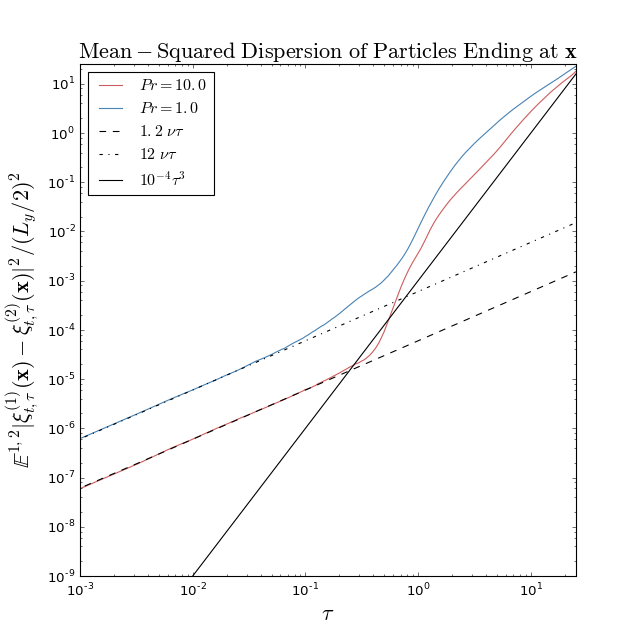

In [25]:
space_point_index = 1

kolmogorov_time = 1
half_Channel_Width = (1/2)*(Top-Bottom)

kappa1 = nu/Prandtl1
kappa2 = nu/Prandtl2
#kappa3 = nu/Prandtl3

Tau = tau/float(kolmogorov_time)
diffusion_dispersion1 = 12*kappa1*Tau
diffusion_dispersion2 = 12*kappa2*Tau
#diffusion_dispersion3 = 12*kappa3*Tau
Richardson_dispersion = 1e-3*Tau**3

disper1 = disp1[:,space_point_index]/float(half_Channel_Width**2)
disper2 = disp2[:,space_point_index]/float(half_Channel_Width**2)
#disper3 = disp3[:,space_point_index]/float(half_Channel_Width**2)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(Tau, disper1, color = 'Indianred', label = '$Pr = {0}$'.format(Prandtl1))
ax.plot(Tau, disper2, color = 'Steelblue', label = '$Pr = {0}$'.format(Prandtl2))
#ax.plot(Tau, disper3, color = 'green', label = '$Pr = {0}$'.format(Prandtl3))
ax.plot(Tau, diffusion_dispersion1,   color = 'black', linestyle = 'dashed',  label = '$1.2\ \\nu\\tau$')
ax.plot(Tau, diffusion_dispersion2,   color = 'black', linestyle = 'dashdot', label = '$12\  \\nu \\tau$')
#ax.plot(Tau, diffusion_dispersion3,   color = 'black', linestyle = 'dotted',  label = '$120\  \\nu \\tau$')
ax.plot(Tau, Richardson_dispersion,   color = 'black', linestyle = 'solid',   label = '$10^{-4} \\tau^3$')
ax.set_xlim([10**(-3),10**(1.4)])
ax.set_ylim([10**(-9),10**(1.4)])
ax.set_title('$\\rm Mean-Squared\ Dispersion\ of\ Particles\ Ending\ at\ \\mathbf{x}$', fontsize=20)
ax.set_xlabel('$\\tau $', fontsize=20)
ax.set_ylabel('$\mathbb{E}^{1,2} |{\\xi}^{(1)}_{t,\\tau}(\\mathbf{x})-{\\xi}^{(2)}_{t,\\tau}(\\mathbf{x})|^2 /(L_y/2)^2$', fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc ="best")